In [303]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler

import tqdm.notebook as tq
import warnings
warnings.filterwarnings('ignore')

import utils_cl
%matplotlib notebook
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparing

In [2]:
full_df = pd.read_csv("dataset/normalized_data.csv")
full_df.columns = ['timestamp','import_kwh','meter_id','is_fraud','date','import_kwh_shift1','consumption']
full_df['timestamp'] = pd.to_datetime(full_df.timestamp)
fraud_milestones = [('PP07000684209001','2017-12-29'),
 ('PP07000670259001','2017-01-03'),
 ('PP07000693227001','2017-08-14'),
 ('PP07000713473001','2017-04-12'),
 ('PP07000662970001','2017-03-02'),
 ('PP07000700839001','2017-05-23'),
 ('PP07000668984001','2017-08-24'),
 ('PP07000683751001','2017-10-25'),
 ('PP07000683750001','2017-10-25'),
 ('PP07000613734001','2017-03-24'),
 ('PP07000673219001','2017-04-24'),
 ('PP07000682085001','2017-10-27'),
 ('PP07000613618001','2017-11-29'),
 ('PP07000600208001','2017-10-05'),
 ('PP07000600209001','2017-10-05'),
 ('PP07000678169001','2017-07-06'),
 ('PP01000134773001','2017-12-12'),
 ('PP01000624985001','2017-12-28'),
 ('PP01000621525001','2017-01-11'),
 ('PP01000117448001','2017-04-14'),
 ('PP01000117849001','2017-10-25'),
 ('PP01000110500001','2017-03-27'),
 ("PP01000103859001","2017-10-30"),
 ('PP01000131431001','2017-04-03'),
 ("PP01000103454001",'2017-08-03'),
 ('PP01000101145001','2017-03-06'),
 ('PP01000140094001','2017-01-09'),
 ('PP01000101975001','2017-02-07'),
 ('PP03000810040001','2017-08-12'),
 ('PP03000832565001','2017-06-13'),
 ('PP03000806717001','2017-07-12'),
 ('PP03000902373001','2017-07-17'),
 ('PP03000809863001','2017-12-19'),
 ('PP03000882852001','2017-12-21'),
 ('PP03000902981001','2017-04-21'),
 ('PP03000804097001','2017-06-24'),
 ('PP03000805922001','2017-09-25'),
 ('PP03000804137001','2017-10-30'),
 ('PP03000904351001','2017-03-28'),
 ('PP03000898466001','2017-06-29'),
 ('PP05000989390001','2017-05-02'),
 ('PP05000948327001','2017-08-10'),
 ('PP05000977900001','2017-01-13'),
 ('PP05000501075001','2017-01-13'),
 ('PP05000501411001','2017-10-13'),
 ('PP05000524904001','2017-04-13'),
 ('PP05000951373001','2017-04-14'),
 ('PP05000967512001','2017-03-15'),
 ('PP05000960339001','2017-03-15'),
 ('PP05000515674001','2017-04-18'),
 ('PP05000967753001','2017-07-20'),
 ('PP05000944240001','2017-05-22'),
 ('PP05000504291001','2017-04-21'),
 ('PP05000968892001','2017-05-22'),
 ('PP05000961578001','2017-05-22'),
 ('PP05000953931001','2017-11-23'),
 ('PP05000502843001','2017-02-24'),
 ('PP05000941329001','2017-11-25'),
 ('PP05000509756001','2017-08-30'),
 ('PP05000524362001','2017-01-04'),
 ('PP05000516894001','2017-04-05'),
 ('PP05000522325001',"2017-12-06"),
 ('PP05000517007001','2017-08-07'),
 ('PP05000515078001','2017-03-09'),
 ('PP05000991348001','2017-05-09'),
 ('PP09000810551001','2017-08-11'),
 ('PP09000884920001','2017-04-11'),
 ('PP09000802199001','2017-09-11'),
 ('PP09000811262001','2017-02-13'),
 ('PP09000120555001','2017-04-17'),
 ('PP09000890287001','2017-02-20'),
 ('PP09000808752001','2017-12-21'),
 ('PP09000817228001','2017-10-24'),
 ('PP09000907245001','2017-11-24'),
 ('PP09000821975001','2017-10-28'),
 ('PP09000837585001','2017-11-28'),
 ('PP09000808816001','2017-12-28'),
 ('PP09000808816001','2017-04-29'),
 ('PP09000892588001','2017-10-31'),
 ('PP09000894390001','2017-10-31'),
 ("PP09000894706001","2017-12-08") 
]

In [3]:
for _id, milestone in fraud_milestones:
    full_df.loc[(full_df.meter_id == _id) & (full_df.date >= milestone),'is_fraud'] = False

In [4]:
full_df['week_index'] = full_df.timestamp.dt.strftime("%a_%H")

full_df['week'] = full_df.timestamp.dt.floor("D") - pd.to_timedelta(full_df.timestamp.dt.weekday, unit='D')

pivot_df = pd.pivot_table(full_df,index = ['meter_id','week','is_fraud'],columns =['week_index'], values = ['consumption'])

In [5]:
pivot_df.head(2)

consumption                      \
week_index                                Fri_00    Fri_06    Fri_12   
meter_id         week       is_fraud                                   
PP01000100340001 2016-12-26 False            NaN       NaN       NaN   
                 2017-01-02 False       0.579663  0.579663  1.051087   

                                                                            \
week_index                              Fri_18   Mon_00   Mon_06    Mon_12   
meter_id         week       is_fraud                                         
PP01000100340001 2016-12-26 False          NaN      NaN      NaN       NaN   
                 2017-01-02 False     0.952474  1.07199  1.07199  0.950588   

                                                                    ...  \
week_index                              Mon_18    Sat_00    Sat_06  ...   
meter_id         week       is_fraud                                ...   
PP01000100340001 2016-12-26 False          NaN       NaN       NaN  ...   
                 2017-01-02 False     1.272025  0.503377  0.503377  ...   

                                                                              \
week_index                              Thu_12    Thu_18    Tue_00    Tue_06   
meter_id         week       is_fraud                                           
PP01000100340001 2016-12-26 False          NaN       NaN       NaN       NaN   
                 2017-01-02 False     0.720422  0.500792  0.521183  0.521183   

                                                                              \
week_index                              Tue_12    Tue_18    Wed_00    Wed_06   
meter_id         week       is_fraud                                           
PP01000100340001 2016-12-26 False          NaN       NaN       NaN       NaN   
                 2017-01-02 False     1.371933  1.025683  0.508946  0.508946   

                                                         
week_index                              Wed_12   Wed_18  
meter_id         week       is_fraud                     
PP01000100340001 2016-12-26 False          NaN      NaN  
                 2017-01-02 False     0.924609  0.75098  

[2 rows x 28 columns]

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(pivot_df)
X = pd.DataFrame(X)

X['label'] = [i[2] for i in pivot_df.index]
X['MA_DIEMDO'] =  [i[0] for i in pivot_df.index]

In [8]:
X.label.value_counts()

False    64941
True      1525
Name: label, dtype: int64

In [9]:
X_train = X.iloc[:, :-2]
Y_train = X.iloc[:, -2].to_list()
Y_mdd = X.iloc[:, -1]

In [10]:
reverse_dict = dict(zip([tuple(list(X_train.iloc[i, :])) for i in range(X_train.shape[0])], list(Y_train)))

In [11]:
reverse_dict_mdd = dict(zip([tuple(list(X_train.iloc[i, :])) for i in range(X_train.shape[0])], list(Y_mdd)))

 ## Clustering

In [300]:
from sklearn.cluster import KMeans

distance_used = utils_cl.distance_ED
cluster_number  = 3
n_iters = 750

km = KMeans(
    n_clusters=cluster_number, init='random',
    n_init=10, max_iter=n_iters,
    tol=1e-04, random_state=200
)

y_km = km.fit_predict(X_train)
centroids = km.cluster_centers_

In [144]:
import skfuzzy as fuzz

distance_used = utils_cl.distance_ED
cluster_number  = 3
n_iters = 750

centroids, u, u0, d, jm, p, fpc  = fuzz.cluster.cmeans(X_train.T, c = cluster_number, m = 2, error=1e-10, maxiter=n_iters)

y_fuzz = [np.argmax([u[j][i] for j in range(cluster_number)]) for i in range(u.shape[1])]
y_km = y_fuzz

In [301]:
count_cluster = [0]*cluster_number
count_fraud = [0]*cluster_number
for i, j in enumerate(y_km):
    count_cluster[j] += 1
    if X.iloc[i, -2]:
        count_fraud[j] += 1
for i in range(cluster_number):
    print("Actual Fraud / Cluster {0} : {1}/{2}".format(i + 1, count_fraud[i], count_cluster[i]))

Actual Fraud / Cluster 1 : 1284/55321
Actual Fraud / Cluster 2 : 240/10099
Actual Fraud / Cluster 3 : 1/1046


In [304]:
# distance of members to center in each cluster
dict_DC = {}
dict_FN = {}

for i in range(cluster_number):
    dict_DC[i+1] = []
    dict_FN[i+1] = []
for i, j in tq.tqdm_notebook(enumerate(y_km), total = len(y_km)):        
    dict_DC[j+1].append(distance_used(centroids[j], X_train.iloc[i, :]))
    dict_FN[j+1].append(Y_train[i])

In [306]:
# radius of each cluster
quantile_radius = []
percentile = 0.9
for j in range(cluster_number):
    quantile_radius.append(pd.DataFrame(dict_DC[j+1]).quantile(percentile, axis = 0)[0])
average_radius = []
for j in range(cluster_number):
    average_radius.append(sum(dict_DC[j+1])/len(dict_DC[j+1]))
max_radius = []
for j in range(cluster_number):
    max_radius.append(max(dict_DC[j+1]))

print("average_radius :",  average_radius)
print("max_radius :",  max_radius)
print("quantile_radius :",  quantile_radius)

average_radius : [1.2017596354549565, 3.0078372615326128, 15.322741867213255]
max_radius : [10.106882040492069, 46.63247260247566, 389.32325562212134]
quantile_radius : [2.0358784727329216, 5.522662703525472, 34.90173712241263]


<IPython.core.display.Javascript object>


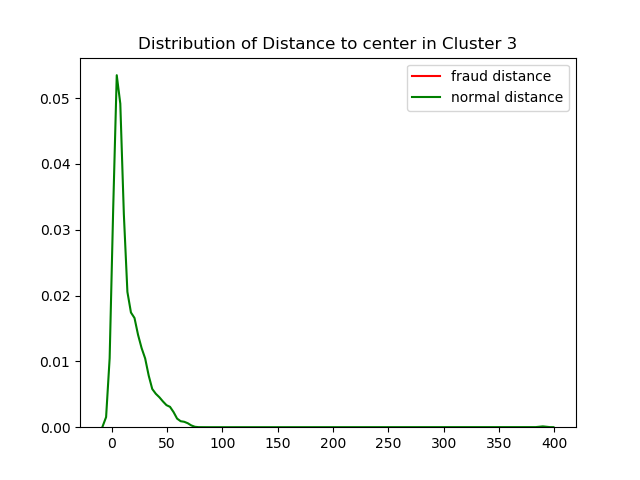

In [307]:
def distribution_plotting(cluster_no):
    color_fraud = 'r'
    color_normal = 'g'
    fraud_distance = []
    normal_distance = []
    for i in range(len(dict_DC[cluster_no])):
        if dict_FN[cluster_no][i]:
            fraud_distance.append(dict_DC[cluster_no][i])
        else :
            normal_distance.append(dict_DC[cluster_no][i])
    sns.kdeplot(fraud_distance, label="fraud distance", color = color_fraud)
    sns.kdeplot(normal_distance, label="normal distance" , color = color_normal)
    plt.legend();
    plt.title("Distribution of Distance to center in Cluster " + str(cluster_no))
distribution_plotting(3)

In [162]:
# Fuzz
def test_fraud_cluster_fuzz(X_sample, X_sample_ind, cluster_belong, radius_cent, thresh_KM):
    contribute_cluster = [u[i][X_sample_ind] for i in range(cluster_number)]
    dist2cent_total = [distance_used(X_sample, cent_i) for cent_i in centroids]
    dist2cent = sum([a*b for (a, b) in zip(contribute_cluster, dist2cent_total)])
    is_fraud = (dist2cent > radius_cent[cluster_belong-1] * thresh_KM)
    return is_fraud

def prediction_result_fuzz(test_set, radius_cent, thresh_KM = 1.0):
    total_fraud = 0
    N = test_set.shape[0]
    mdd_fraud_1week = []
    Y_predict = []
    ind_fraud_predicted = []
    count_fraud_predicted = [0]*cluster_number
    for i in (range(N)):
        X_sample = test_set.iloc[i, :]
        cluster_belong = y_km[i] + 1
        test_result = test_fraud_cluster_fuzz(X_sample, i, cluster_belong, radius_cent, thresh_KM)
        if test_result == True :
            count_fraud_predicted[cluster_belong-1]+=1
            mdd_fraud_1week.append(reverse_dict_mdd[tuple(X_sample)])
            ind_fraud_predicted.append(i)
        Y_predict.append(test_result)
    return list(set(mdd_fraud_1week)), Y_predict, ind_fraud_predicted,count_fraud_predicted

In [184]:
# Fuzz 2
def test_fraud_cluster_fuzz_2(X_sample_ind, cluster_belong, radius_cent, thresh_KM):
    contribute_cluster = [u[i][X_sample_ind] for i in range(cluster_number)]
    thres_contribution_max = 0.8
    thres_contribution_min = 1 - thres_contribution_max
    is_fraud = (max(contribute_cluster) < thres_contribution_max)
    return is_fraud

def prediction_result_fuzz_2(test_set, radius_cent, thresh_KM = 1.0):
    total_fraud = 0
    N = test_set.shape[0]
    mdd_fraud_1week = []
    Y_predict = []
    ind_fraud_predicted = []
    count_fraud_predicted = [0]*cluster_number
    for i in (range(N)):
        X_sample = test_set.iloc[i, :]
        cluster_belong = y_km[i] + 1
        test_result = test_fraud_cluster_fuzz_2(i, cluster_belong, radius_cent, thresh_KM)
        if test_result == True :
            count_fraud_predicted[cluster_belong-1]+=1
            mdd_fraud_1week.append(reverse_dict_mdd[tuple(X_sample)])
            ind_fraud_predicted.append(i)
        Y_predict.append(test_result)
    return list(set(mdd_fraud_1week)), Y_predict, ind_fraud_predicted,count_fraud_predicted

In [308]:
# KM
def test_fraud_cluster(X_sample, cluster_belong, radius_cent, thresh_KM):
    dist2cent = distance_used(X_sample, centroids[cluster_belong - 1])
    is_fraud = (dist2cent > radius_cent[cluster_belong-1] * thresh_KM)
    return is_fraud

def prediction_result(test_set, radius_cent, thresh_KM = 1.0):
    total_fraud = 0
    N = test_set.shape[0]
    mdd_fraud_1week = []
    Y_predict = []
    ind_fraud_predicted = []
    count_fraud_predicted = [0]*cluster_number
    for i in tq.tqdm_notebook(range(N)):
        X_sample = test_set.iloc[i, :]
        cluster_belong = y_km[i] + 1
        test_result = test_fraud_cluster(X_sample, cluster_belong, radius_cent, thresh_KM)
        if test_result == True :
            count_fraud_predicted[cluster_belong-1]+=1
            mdd_fraud_1week.append(X.iloc[i, -1])
            ind_fraud_predicted.append(i)
        Y_predict.append(test_result)
    return list(set(mdd_fraud_1week)), Y_predict, ind_fraud_predicted,count_fraud_predicted

In [309]:
test_set = X_train
radius_cent = quantile_radius
thresh_KM = 1
mdd_fraud_1week, Y_predict, ind_fraud_predicted, count_fraud_predicted = prediction_result(test_set, radius_cent, thresh_KM)

In [310]:
total_fraud = X[X.label == True].MA_DIEMDO.unique()
total_normal = X[X.label == False].MA_DIEMDO.unique()
count_fraud_predicted

[5235, 1010, 105]

In [311]:
len(list(set(total_fraud) & set(mdd_fraud_1week)))

46

In [312]:
from sklearn.metrics import confusion_matrix
x = confusion_matrix(Y_train, Y_predict)
#tp, fp, fn, tn = x[0][0], x[0][1], x[1][0], x[1][1]
print(x)

[[58983  5958]
 [ 1133   392]]


## Pred mdd

In [313]:
len(mdd_fraud_1week)

614

In [314]:
consecutive_week = 3

In [315]:
test_df = pd.DataFrame()
test_df['MA_DIEMDO'] = X.MA_DIEMDO
test_df['PRED'] = Y_predict
test_df = test_df.groupby(['MA_DIEMDO'])['PRED'].apply(list)

In [316]:
def test_consecutive_week(l):
    n = len(l)
    for i in range(n) :
        if l[i] == True:
            if sum(l[i : i+consecutive_week]) == consecutive_week:
                return True
        else :
            continue
    return False

mdd_fraud_n_week = []
for i in range(test_df.shape[0]):
    l = test_df[i]
    if test_consecutive_week(l):
        mdd_fraud_n_week.append(test_df.index[i])
        

In [317]:
len(mdd_fraud_n_week)

329

In [318]:
len(list(set(total_fraud) & set(mdd_fraud_n_week)))

31

In [280]:
mdd_fraud_n_week

['PP01000101975001',
 'PP01000104793001',
 'PP01000108429001',
 'PP01000109388001',
 'PP01000116714001',
 'PP01000117448001',
 'PP01000121133001',
 'PP01000121873001',
 'PP01000126359001',
 'PP01000132290001',
 'PP01000134449001',
 'PP01000135301001',
 'PP01000141123001',
 'PP01000146244001',
 'PP01000147159001',
 'PP01000151596001',
 'PP01000617599001',
 'PP01000619774001',
 'PP01000622443001',
 'PP01000623778001',
 'PP01000624985001',
 'PP01000632976001',
 'PP01000639500001',
 'PP01000639966001',
 'PP01000641772001',
 'PP01000646047001',
 'PP03000805922001',
 'PP03000806717001',
 'PP03000808102001',
 'PP03000809863001',
 'PP03000810040001',
 'PP03000811957001',
 'PP03000812655001',
 'PP03000822079001',
 'PP03000824891001',
 'PP03000826791001',
 'PP03000828095001',
 'PP03000828101001',
 'PP03000830038001',
 'PP03000831003001',
 'PP03000831289001',
 'PP03000836085001',
 'PP03000838936001',
 'PP03000839340001',
 'PP03000839851001',
 'PP03000840793001',
 'PP03000841803001',
 'PP030008434